<a href="https://colab.research.google.com/github/SuryanshNaugraiya/Bitcoin_Prediction_System/blob/master/LSTM_MULTIVARIATE_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'high'

In [ ]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2016-08-06,586.45,596.68,565.33,574.66,25382.28,14676841.26
2016-08-07,590.85,596.01,580.87,586.45,26202.24,15491523.10
2016-08-08,589.24,594.24,585.41,590.85,24880.83,14726811.56
2016-08-09,585.25,591.20,581.10,589.24,25971.47,15304277.91
2016-08-10,590.94,600.52,580.87,585.25,49568.68,29376783.81


In [ ]:
hist=hist.drop(labels=['volumefrom','volumeto'],axis=1)

In [ ]:
hist

,close,high,low,open
time,,,,
2016-08-06,586.45,596.68,565.33,574.66
2016-08-07,590.85,596.01,580.87,586.45
2016-08-08,589.24,594.24,585.41,590.85
2016-08-09,585.25,591.20,581.10,589.24
2016-08-10,590.94,600.52,580.87,585.25
...,...,...,...,...
2020-09-10,10345.68,10493.32,10221.37,10228.85
2020-09-11,10398.50,10412.60,10215.49,10345.68
2020-09-12,10448.00,10486.76,10282.43,10398.50


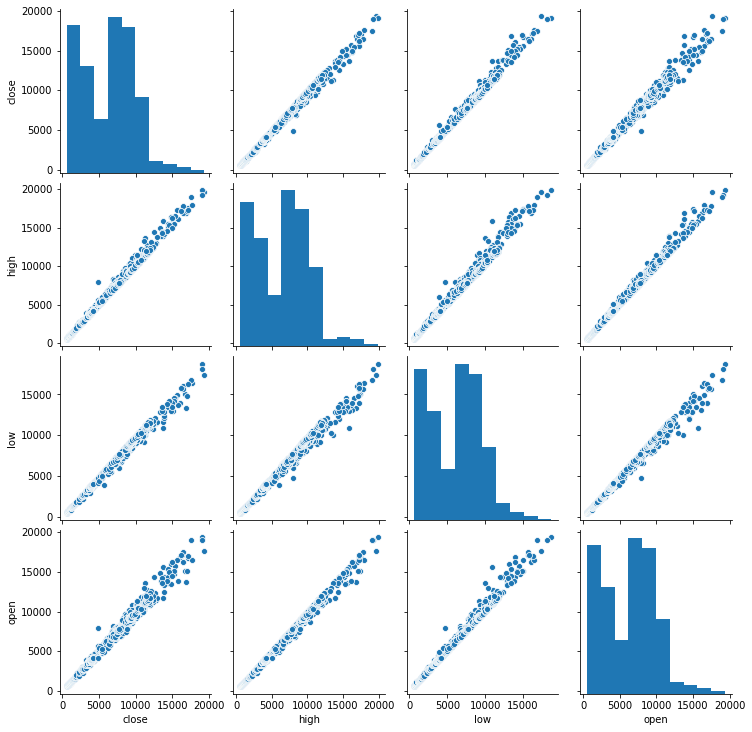

In [ ]:
sns.pairplot(hist)

In [ ]:
hist.corr()

,close,high,low,open
close,1.000000,0.998042,0.997595,0.995753
high,0.998042,1.000000,0.995278,0.997836
low,0.997595,0.995278,1.000000,0.996261
open,0.995753,0.997836,0.996261,1.000000


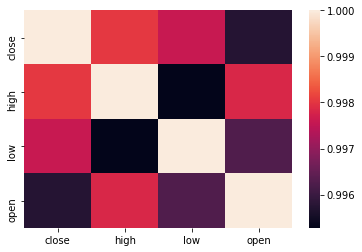

In [ ]:
sns.heatmap(hist.corr())

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

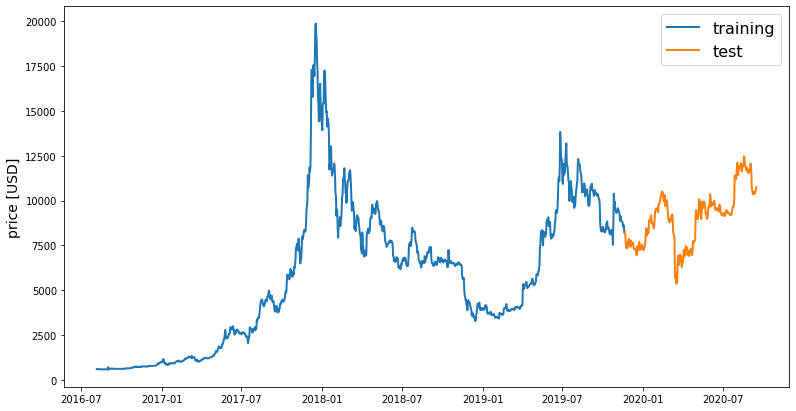

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 26
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 2/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 3/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 4/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 6/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 7/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 8/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 9/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 10/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 11/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 12/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 13/20
46/46 [==============================

In [ ]:
from sklearn.metrics import mean_squared_error
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_squared_error(preds, y_test)



0.0007238636261250205

In [ ]:
mean_absolute_error(preds, y_test)

0.018418248307154512

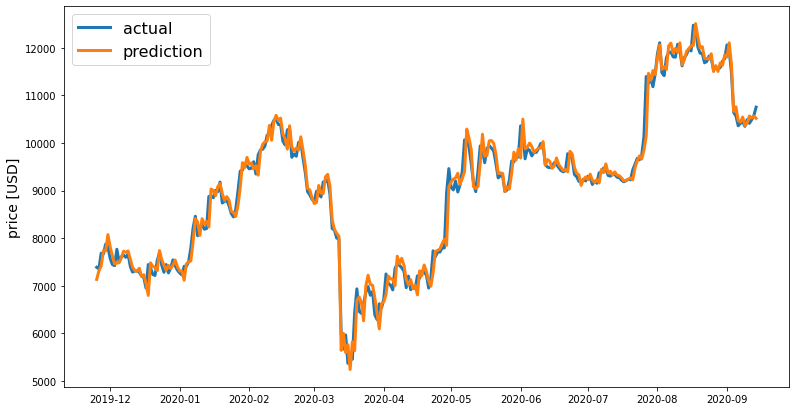

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)